#Segmentation in keras and pytorch
Semantic segmentation is a fundamental task within computer vision which entails assigning class labels to individual pixels in an image

In this notebook we will look at how to build and train a [U-Net style metwork](https://arxiv.org/abs/1505.04597) for segmentation of pets in images from the [Oxford-IIT Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

#Keras
Unet using the Keras functional API

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define the U-Net architecture using the Functional API
def unet(input_shape=(256, 256, 3), num_classes=1):
    # Input layer
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom layer
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, 1, activation='sigmoid')(conv7)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    return model

# Create a U-Net model with input shape (256, 256, 3) and one output channel
model = unet(input_shape=(256, 256, 3), num_classes=1)

# Compile the model (you can choose an appropriate optimizer and loss function for your task)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

#Pytorch
Unet using the torch nn module

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self,x):
      x = self.block(x)
      return x

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        self.block = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )


    def forward(self,x):
        x = self.block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()


        self.e1 = encoder_block(in_channels,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)



        self.d1 = decoder_block(512,256)
        self.d2 = decoder_block(512,128)
        self.d3 = decoder_block(256,64)

        self.seg_block = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,out_channels,kernel_size=1),
            nn.Sigmoid())


    def forward(self, x):
        # Encode
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)

        #decode
        x5 = self.d1(x4)

        x5 = torch.cat([x5,x3],1)

        x6 = self.d2(x5)

        x6 = torch.cat([x6,x2],1)

        x7 = self.d3(x6)

        x7 = torch.cat([x7,x1],1)

        x7 = self.seg_block(x7)


        return x7

# Create a U-Net model with 3 input channels and 1 output channel
model = UNet(in_channels=3, out_channels=1)

if torch.cuda.is_available():
    model.cuda()
# Print the model summary
#
print(summary(model,(3,256,256),1))


#Training a Keras model

This tutorial uses a U-Net like architecture for image segmentation. Data processing and augmentations are implemented with KerasCV.

U-Net was introduced in the paper, [U-Net: Convolutional Networks for Biomedical Image Segmentation.](https://arxiv.org/abs/1505.04597)

First let's set up install and imports of the dependencies.

To run this tutorial, you will need to install keras-cv with the following command: pip install keras-cv

In [ ]:
%pip install keras-cv

In [ ]:
import tensorflow as tf
from tensorflow import keras

import random
import keras_cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


#Configuration

Please feel free to tweak the configurations yourself and note how the model training changes. This is an excellent exercise to get a better understanding of the training pipeline.

In [ ]:

# Image Config
HEIGHT = 160
WIDTH = 160
NUM_CLASSES = 3

# Augmentation Config
ROTATION_FACTOR = (-0.2, 0.2)

# Training Config
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE


#Download the data

We download the Oxford-IIT Pet dataset with TensorFlow Datasets (TFDS) with one line of code. Combine the training and test data, and then split the combined data into 80% training dataset and 20% test dataset (used later on for both validation and testing).

In [ ]:
import tensorflow_datasets as tfds
orig_train_ds, orig_val_ds = tfds.load(
    name="oxford_iiit_pet",
    split=["train+test[:80%]", "test[80%:]"],
)

#Preprocess the data

Here we processes the images and segmentation masks in the inputs dictionary, mapping the image pixel intensities from [0, 255] to the range [0.0, 1.0] and adjusting segmentation masks indices from 1-based to 0-based.

Also note the renaming of the keys of the dictionary. The processed datasets are formatted suitably for KerasCV layers, which expect inputs in a specific dictionary format.

In [ ]:
rescale_images_and_correct_masks = lambda inputs: {
    "images": tf.cast(inputs["image"], dtype=tf.float32) / 255.0,
    "segmentation_masks": inputs["segmentation_mask"] - 1,
}


train_ds = orig_train_ds.map(
    rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE
)
val_ds = orig_val_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

#Utility function
The unpackage_inputs is a utility function that is used to unpack the inputs from the dictionary format to a tuple of (images, segmentation_masks). This will be used later on for visualizing the images and segmentation masks and also the model predictions.

In [ ]:

def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks


#Visualize data
Let's visualized a few images and their segmentation masks from the training data, with the keras_cv.visualization.plot_segmentation_mask_gallery API.

In [ ]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(4)
images, segmentation_masks = next(iter(plot_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)


#Data Augmentation

We resize both the images and masks to the width/height as specified. Then use KerasCV's RandomFlip, RandomRotation and RandAugment to apply image augmentation of random flip, random rotation.

We only apply the resizing operation to the validation dataset

In [ ]:
resize_fn = keras_cv.layers.Resizing(
    HEIGHT,
    WIDTH,
)

augment_fn = keras.Sequential(
    [
        resize_fn,
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomRotation(
            factor=ROTATION_FACTOR,
            segmentation_classes=NUM_CLASSES,
        )
    ]
)


Create training and validation datasets.

In [ ]:
augmented_train_ds = (
    train_ds.shuffle(BATCH_SIZE * 2)
    .map(augment_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
resized_val_ds = (
    val_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


#Visualize augmented data

Now let's again visualize a few of the images and their segmentation masks with the keras_cv.visualization.plot_segmentation_mask_gallery API. Note the effects from the data augmentation.

In [ ]:
images, segmentation_masks = next(iter(augmented_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)


#Model architecture

The U-Net consists of an encoder for downsampling and a decoder for upsampling with skip connections.

The model architecture shapes like the letter U hence the name U-Net.

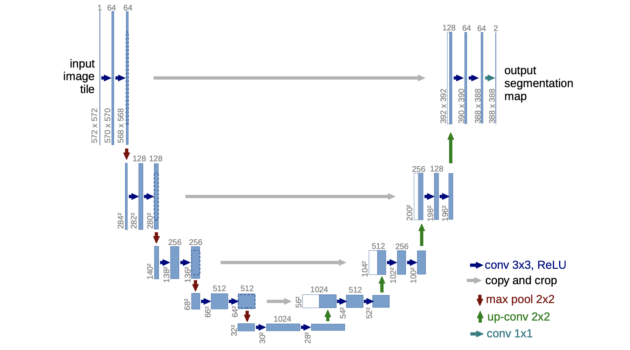

We reuse the code for implementation of a functional keras model presented above.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Image Config
HEIGHT = 160
WIDTH = 160
NUM_CLASSES = 3


# Define the U-Net architecture using the Functional API
def unet(input_shape=(160, 160, 3), num_classes=3):
    # Input layer
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom layer
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, 1, activation='softmax')(conv7)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    return model

model = unet(input_shape=(HEIGHT, WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

We subclass Callback to monitor the model training progress: training and validation loss, and visually inspect the images, predicted masks and ground truth masks.

In [ ]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_masks = next(iter(resized_val_ds))

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            pred_masks = self.model.predict(test_images)
            pred_masks = tf.math.argmax(pred_masks, axis=-1)
            pred_masks = pred_masks[..., tf.newaxis]

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = pred_masks[random_index]
            random_true_mask = test_masks[random_index]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image: {epoch:03d}")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(
                f"Predicted Mask: {epoch:03d}",
            )

            plt.show()
            plt.close()


callbacks = [DisplayCallback(5)]


#Train the model

Now let's create the model, compile and train it for 50 epochs by calling model.fit().

To speed up training go change the notebooks settings to use GPU hardware acceleration. You may need to run specific relevant cells of the notebook again after changing the accelartor.

In [ ]:
# Build model
model = unet(input_shape = (HEIGHT,WIDTH,3), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model, doing validation at the end of each epoch.
history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    validation_data=resized_val_ds,
    callbacks=callbacks,
)


#Training a Pytorch model

setting up the data pipeline

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os
from torchvision import transforms
from PIL import Image
import torchvision
from torch.utils.data import DataLoader
import os
from matplotlib.pyplot import imshow
from enum import IntEnum

%matplotlib inline


working_dir = os.getcwd() #change the directory if you want


# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)


Dataset_dir = f'{working_dir}/OxfordPets'

hparams = {"batch_size": 16
          }


class SemanticDataset(Dataset):
    def __init__(self,train=False,test=False,transform=None):
        if(train):
            self.file_path_images=os.path.join((os.getcwd()),f'{Dataset_dir}/train/oxford-iiit-pet/images/')
            self.file_path_labels=os.path.join((os.getcwd()),f'{Dataset_dir}/train/oxford-iiit-pet/annotations/trimaps/')

        if(test):
            self.file_path_images=os.path.join((os.getcwd()),f'{Dataset_dir}/test/oxford-iiit-pet/images/')
            self.file_path_labels=os.path.join((os.getcwd()),f'{Dataset_dir}/test/oxford-iiit-pet/annotations/trimaps/')

        self.transform_image=transforms.Compose([transforms.Resize((160, 160)),transforms.ToTensor()])
        self.transform_label=transforms.Compose([transforms.Resize((160, 160)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=1,std=1)
                                                 ])

        self.file_list_images=[os.path.splitext(filename)[0] for filename in os.listdir(self.file_path_images)]
        self.file_list_labels=[x+".png" for x in self.file_list_images]
        self.file_list_images=[x+".jpg" for x in self.file_list_images]

        print("Loaded ",len(self.file_list_images)," Images")


    def __len__(self):
        return len(self.file_list_images)

    def __getitem__(self,idx):

        image_path=os.path.join(self.file_path_images,self.file_list_images[idx])
        label_path=os.path.join(self.file_path_labels,self.file_list_labels[idx])

        image=Image.open(image_path)
        label=Image.open(label_path)


        return self.transform_image(image),self.transform_label(label).type(torch.LongTensor)

    def show_image(self,idx):
        image_path=os.path.join(self.file_path_images,self.file_list_images[idx])

        image=np.array(Image.open(image_path))
        image=Image.fromarray(image)
        image=image.convert('RGB')
        imshow(self.tranform_image(image))


    def show_label(self,idx):
        label_path=os.path.join(self.file_path_labels,self.file_list_labels[idx])

        image=np.array(Image.open(label_path))*80.0
        image=Image.fromarray(image)
        image=image.convert('L')
        imshow(self.transform_label(image))

    def load_image(self,idx):

        if type(idx) == list:
          ims = []
          for id_ in idx:

              image_path=os.path.join(self.file_path_images,self.file_list_images[id_])

              image=np.array(Image.open(image_path))
              image=Image.fromarray(image)
              image=image.convert('RGB')
              ims.append(image)
          return ims
        else:
              image_path=os.path.join(self.file_path_images,self.file_list_images[idx])
              image=np.array(Image.open(image_path))
              image=Image.fromarray(image)
              image=image.convert('RGB')
              return image


    def load_label(self,idx):

        if type(idx) == list:
          ims = []
          for id_ in idx:
            label_path=os.path.join(self.file_path_labels,self.file_list_labels[id_])
            image=np.array(Image.open(label_path))*80
            image=Image.fromarray(image)
            image=image.convert('L')

            ims.append(image)

          return ims

        else:
            label_path=os.path.join(self.file_path_labels,self.file_list_labels[idx])
            image=np.array(Image.open(label_path))*80
            image=Image.fromarray(image)
            image=image.convert('L')
            return image


train_data = SemanticDataset(train=True, test=False, transform=None)

train_dataloader = DataLoader(
    train_data, batch_size=hparams["batch_size"], num_workers=2)

test_data = SemanticDataset(train=False, test=True, transform=None)
test_dataloader = DataLoader(
    test_data, batch_size=hparams["batch_size"], num_workers=2)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}, type: {type(train_labels)}")


Show some example images and labels

In [ ]:
import matplotlib.pyplot as plt
import random

idx =  random.sample(range(0, len(train_data)), 10)

images = train_data.load_image(idx)

labels = train_data.load_label(idx)

fig = plt.figure(figsize=(10, 10))

columns = 2
rows = 5
for i in range(1, (columns*rows)+1):
    fig.add_subplot(rows, columns, i)
    im = images[i-1]
    lbl = labels[i-1]
    im = im.resize((160,160))
    lbl = lbl.resize((160,160))
    im = np.concatenate((im,np.dstack([np.expand_dims(lbl,-1)]*3)),axis=1)
    plt.axis('off')
    plt.imshow(im)


plt.show()


Define model

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self,x):
      x = self.block(x)
      return x

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        self.block = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )


    def forward(self,x):
        x = self.block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()


        self.e1 = encoder_block(in_channels,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)



        self.d1 = decoder_block(512,256)
        self.d2 = decoder_block(512,128)
        self.d3 = decoder_block(256,64)

        self.seg_block = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,out_channels,kernel_size=1),
            nn.Softmax())


    def forward(self, x):
        # Encode
        x1 = self.e1(x)
        x2 = self.e2(x1)
        x3 = self.e3(x2)
        x4 = self.e4(x3)

        #decode
        x5 = self.d1(x4)

        x5 = torch.cat([x5,x3],1)

        x6 = self.d2(x5)

        x6 = torch.cat([x6,x2],1)

        x7 = self.d3(x6)

        x7 = torch.cat([x7,x1],1)

        x7 = self.seg_block(x7)


        return x7

# Create a U-Net model with 3 input channels and 3 output channel
model = UNet(in_channels=3, out_channels=3)

if torch.cuda.is_available():
    model.cuda()
# Print the model summary
#
print(summary(model,(3,160,160),3))

model.to(device)


Define a training loop

In [ ]:

from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model for some steps
def train_model(model, loader, optimizer):

    criterion = nn.CrossEntropyLoss(reduction='mean')

    running_loss = 0.0
    running_samples = 0
    for batch_idx in tqdm(range(0,(len(train_data)//20)//hparams['batch_size'])):
        inputs, targets = next(iter(loader))


        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        targets = targets.squeeze(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += targets.size(0)
        running_loss += loss.item()

    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))


Train the model

In [ ]:
train_model(model,train_dataloader,torch.optim.Adam(model.parameters(), lr=0.001))